In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape

In [ ]:
class DCGAN:
	@staticmethod
	def build_generator(dim, depth, channels=1, inputDim=100,
		outputDim=512):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (dim, dim, depth)
		chanDim = -1

    # first set of FC => RELU => BN layers
		model.add(Dense(input_dim=inputDim, units=outputDim))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
  
		# second set of FC => RELU => BN layers, this time preparing
		# the number of FC nodes to be reshaped into a volume
		model.add(Dense(dim * dim * depth))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
  
    # reshape the output of the previous layer set, upsample +
		# apply a transposed convolution, RELU, and BN
		model.add(Reshape(inputShape))
		model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
			padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
  
    # apply another upsample and transposed convolution, but
		# this time output the TANH activation
		model.add(Conv2DTranspose(channels, (5, 5), strides=(2, 2),
			padding="same"))
		model.add(Activation("tanh"))
		# return the generator model
		return model

	@staticmethod
	def build_discriminator(width, height, depth, alpha=0.2):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)
		# first set of CONV => RELU layers
		model.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
			input_shape=inputShape))
		model.add(LeakyReLU(alpha=alpha))
		# second set of CONV => RELU layers
		model.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
		model.add(LeakyReLU(alpha=alpha))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(LeakyReLU(alpha=alpha))
		# sigmoid layer outputting a single value
		model.add(Dense(1))
		model.add(Activation("sigmoid"))
		# return the discriminator model
		return model

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from sklearn.utils import shuffle
from imutils import build_montages
import numpy as np
import cv2
import os

In [ ]:
# store the epochs and batch size in convenience variables, then
# initialize our learning rate
NUM_EPOCHS = 50
BATCH_SIZE = 32
INIT_LR = 2e-4

# load the Fashion MNIST dataset and stack the training and testing
# data points so we have additional training data
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = fashion_mnist.load_data()
trainImages = np.concatenate([trainX, testX])
# add in an extra dimension for the channel and scale the images
# into the range [-1, 1] (which is the range of the tanh
# function)
trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

[INFO] loading MNIST dataset...
4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# build the generator
print("[INFO] building generator...")
gen = DCGAN.build_generator(7, 64, channels=1)
# build the discriminator
print("[INFO] building discriminator...")
disc = DCGAN.build_discriminator(28, 28, 1)
discOpt = Adam(lr=INIT_LR, beta_1=0.5, decay=INIT_LR / NUM_EPOCHS)
disc.compile(loss="binary_crossentropy", optimizer=discOpt)

# build the adversarial model by first setting the discriminator to
# *not* be trainable, then combine the generator and discriminator
# together
print("[INFO] building GAN...")
disc.trainable = False
ganInput = Input(shape=(100,))
ganOutput = disc(gen(ganInput))
gan = Model(ganInput, ganOutput)
# compile the GAN
ganOpt = Adam(lr=INIT_LR, beta_1=0.5, decay=INIT_LR / NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building generator...
[INFO] building discriminator...
[INFO] building GAN...


In [ ]:
# randomly generate some benchmark noise so we can consistently
# visualize how the generative modeling is learning
print("[INFO] starting training...")
benchmarkNoise = np.random.uniform(-1, 1, size=(256, 100))
# loop over the epochs
for epoch in range(0, NUM_EPOCHS):
	# show epoch information and compute the number of batches per
	# epoch
	print("[INFO] starting epoch {} of {}...".format(epoch + 1,
		NUM_EPOCHS))
	batchesPerEpoch = int(trainImages.shape[0] / BATCH_SIZE)
	# loop over the batches
	for i in range(0, batchesPerEpoch):
		# initialize an (empty) output path
		p = None
		# select the next batch of images, then randomly generate
		# noise for the generator to predict on
		imageBatch = trainImages[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
		noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
  
    # generate images using the noise + generator model
		genImages = gen.predict(noise, verbose=0)
		# concatenate the *actual* images and the *generated* images,
		# construct class labels for the discriminator, and shuffle
		# the data
		X = np.concatenate((imageBatch, genImages))
		y = ([1] * BATCH_SIZE) + ([0] * BATCH_SIZE)
		y = np.reshape(y, (-1,))
		(X, y) = shuffle(X, y)
		# train the discriminator on the data
		discLoss = disc.train_on_batch(X, y)
  
    # let's now train our generator via the adversarial model by
		# (1) generating random noise and (2) training the generator
		# with the discriminator weights frozen
		noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
		fakeLabels = [1] * BATCH_SIZE
		fakeLabels = np.reshape(fakeLabels, (-1,))
		ganLoss = gan.train_on_batch(noise, fakeLabels)
  
    # check to see if this is the end of an epoch, and if so,
		# initialize the output path
		if i == batchesPerEpoch - 1:
			p = ["/content/drive/MyDrive/Colab Notebooks/GAN_output", "epoch_{}_output.png".format(
				str(epoch + 1).zfill(4))]
		# otherwise, check to see if we should visualize the current
		# batch for the epoch
		else:
			# create more visualizations early in the training
			# process
			if epoch < 10 and i % 25 == 0:
				p = ["/content/drive/MyDrive/Colab Notebooks/GAN_output", "epoch_{}_step_{}.png".format(
					str(epoch + 1).zfill(4), str(i).zfill(5))]
			# visualizations later in the training process are less
			# interesting
			elif epoch >= 10 and i % 100 == 0:
				p = ["/content/drive/MyDrive/Colab Notebooks/GAN_output", "epoch_{}_step_{}.png".format(
					str(epoch + 1).zfill(4), str(i).zfill(5))]

    # check to see if we should visualize the output of the
		# generator model on our benchmark data
		if p is not None:
			# show loss information
			print("[INFO] Step {}_{}: discriminator_loss={:.6f}, "
				"adversarial_loss={:.6f}".format(epoch + 1, i,
					discLoss, ganLoss))
			# make predictions on the benchmark noise, scale it back
			# to the range [0, 255], and generate the montage
			images = gen.predict(benchmarkNoise)
			images = ((images * 127.5) + 127.5).astype("uint8")
			images = np.repeat(images, 3, axis=-1)
			vis = build_montages(images, (28, 28), (16, 16))
			# write the visualization to disk
			p = os.path.sep.join(p)
			cv2.imwrite(p, vis)

[INFO] starting training...
[INFO] starting epoch 1 of 50...
[INFO] Step 1_0: discriminator_loss=0.558582, adversarial_loss=0.480834
[INFO] Step 1_25: discriminator_loss=0.039493, adversarial_loss=0.008815
[INFO] Step 1_50: discriminator_loss=0.000582, adversarial_loss=0.001334
[INFO] Step 1_75: discriminator_loss=0.000290, adversarial_loss=0.000880
[INFO] Step 1_100: discriminator_loss=0.000030, adversarial_loss=0.000319
[INFO] Step 1_125: discriminator_loss=0.000026, adversarial_loss=0.000259
[INFO] Step 1_150: discriminator_loss=0.000036, adversarial_loss=0.000242
[INFO] Step 1_175: discriminator_loss=0.000051, adversarial_loss=0.000201
[INFO] Step 1_200: discriminator_loss=0.000121, adversarial_loss=0.000236
[INFO] Step 1_225: discriminator_loss=0.000122, adversarial_loss=0.000324
[INFO] Step 1_250: discriminator_loss=0.000567, adversarial_loss=0.000385
[INFO] Step 1_275: discriminator_loss=0.115627, adversarial_loss=2.065012
[INFO] Step 1_300: discriminator_loss=0.181993, adversar

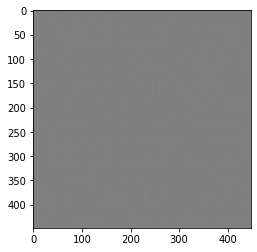

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/drive/MyDrive/Colab Notebooks/GAN_output/epoch_0001_step_00000.png")

plt.imshow(img)
plt.show()

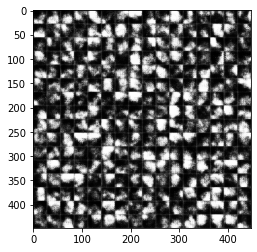

In [ ]:

img = Image.open("/content/drive/MyDrive/Colab Notebooks/GAN_output/epoch_0001_step_00300.png")

plt.imshow(img)
plt.show()

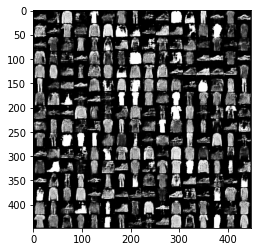

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/GAN_output/epoch_0001_output.png")

plt.imshow(img)
plt.show()

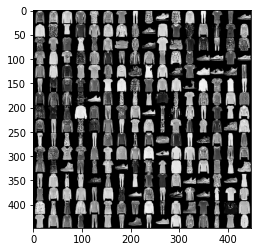

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/GAN_output/epoch_0040_output.png")

plt.imshow(img)
plt.show()